<a href="https://colab.research.google.com/github/AlexeyUdod/aml/blob/master/dll_13_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Задание 
1. Скачать датасет с фразами симпосонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
2. Обучить word2vec на фразах персонажей
3. Визуаилизировать embeddings по самым частотным словам (top 1000)
4. Найти самые близкие слова для: homer - marge + bart bart - lisa + school marge - homer + home
5. попробовать построить классификатор bart/lisa с использованием этих эмбеддингов

In [1]:
import torch as tr 
from gensim.models import Word2Vec
import pandas as pd
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = '/content/drive/My Drive/Colab Notebooks/dll/'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv(path + 'simpsons_script_lines.csv', error_bad_lines=False)
text_y = np.array([[''.join(re.findall(f'[a-z ]', t)), y] for t, y  in zip(data.normalized_text.to_list(), data.raw_character_text.to_list()) if type(t) is str])
text = text_y[:,0]
sents = [sent.split(' ') for sent in text]
model = Word2Vec(sents, min_count=1)

b'Skipping line 8084: expected 13 fields, saw 20\nSkipping line 52607: expected 13 fields, saw 21\nSkipping line 59910: expected 13 fields, saw 21\n'
b'Skipping line 71801: expected 13 fields, saw 20\nSkipping line 73539: expected 13 fields, saw 21\nSkipping line 77230: expected 13 fields, saw 21\nSkipping line 78953: expected 13 fields, saw 21\nSkipping line 81138: expected 13 fields, saw 20\nSkipping line 86746: expected 13 fields, saw 22\nSkipping line 101154: expected 13 fields, saw 21\nSkipping line 115438: expected 13 fields, saw 20\nSkipping line 117573: expected 13 fields, saw 22\nSkipping line 130610: expected 13 fields, saw 22\n'
b'Skipping line 152970: expected 13 fields, saw 22\nSkipping line 153017: expected 13 fields, saw 20\nSkipping line 153018: expected 13 fields, saw 30\nSkipping line 154080: expected 13 fields, saw 20\nSkipping line 154082: expected 13 fields, saw 20\nSkipping line 154084: expected 13 fields, saw 20\nSkipping line 154086: expected 13 fields, saw 20\n

In [ ]:
words1000 = list(model.wv.index2entity[:1000])
vec1000 = model.wv[model.wv.index2entity[:1000]]
pca = PCA(n_components = 2)
res = pca.fit_transform(vec1000)

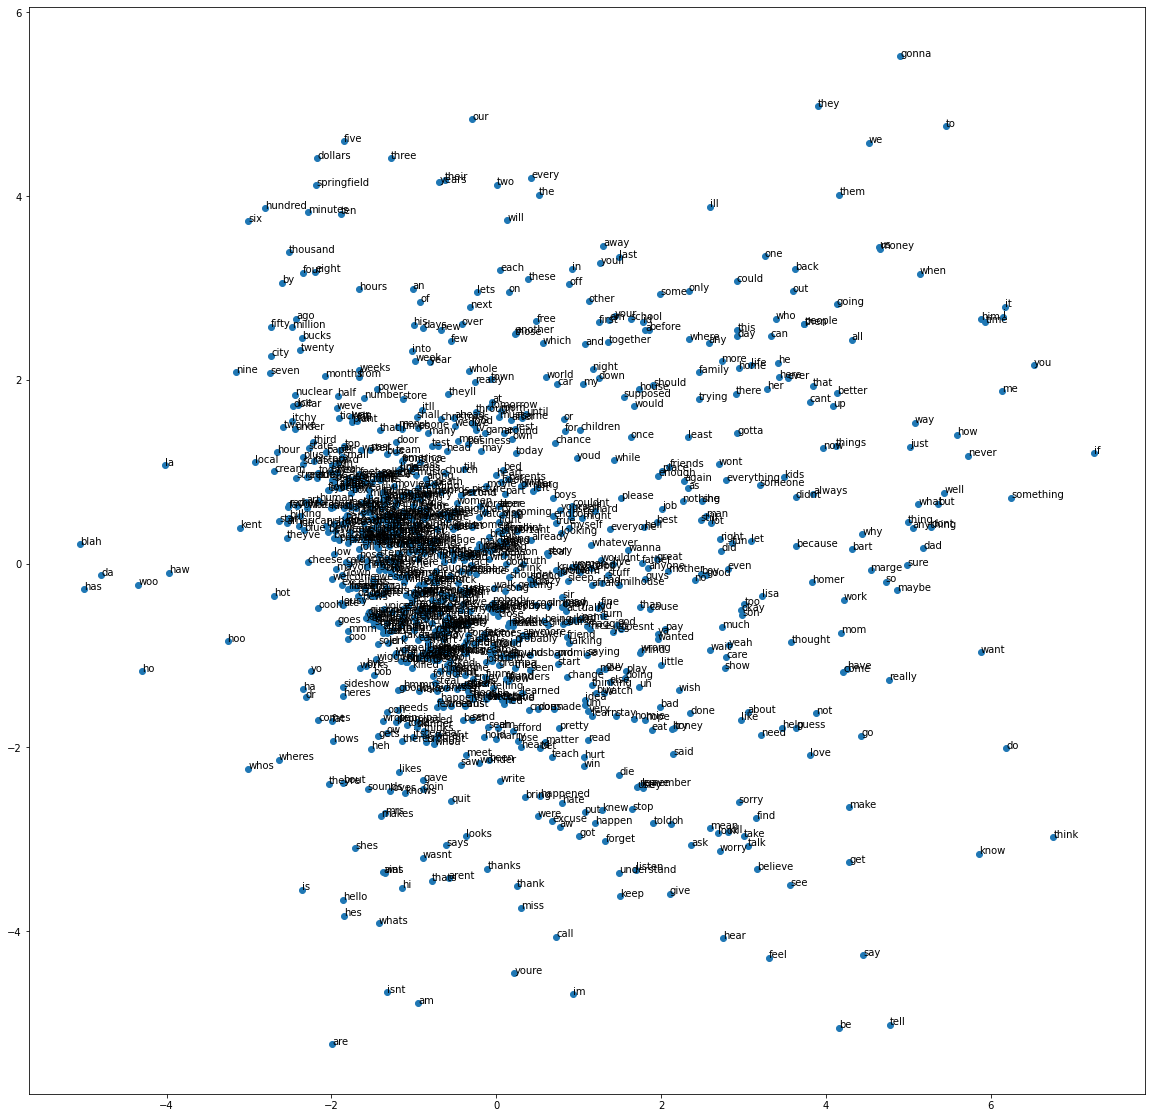

In [ ]:
plt.scatter(res[:,0], res[:,1])
for i, word in enumerate(words1000):
	  plt.annotate(word, xy=(res[i, 0], res[i, 1]))
plt.gcf().set_size_inches(20, 20)

In [ ]:
print(f"homer - marge + bart:\n {model.wv.most_similar(positive=['homer', 'bart'], negative=['marge'])}\n")
print(f"bart - lisa + school:\n {model.wv.most_similar(positive=['school', 'bart'], negative=['lisa'])}\n")
print(f"marge - homer + home:\n {model.wv.most_similar(positive=['marge', 'home'], negative=['homer'])}\n")

homer - marge + bart:
 [('lisa', 0.8320844173431396), ('grampa', 0.7166217565536499), ('milhouse', 0.6848677396774292), ('son', 0.6786609888076782), ('abe', 0.6648697853088379), ('pjs', 0.6644101142883301), ('dad', 0.6491702198982239), ('maggie', 0.6367762088775635), ('mr', 0.6344897150993347), ('family', 0.6333332657814026)]

bart - lisa + school:
 [('house', 0.7696906328201294), ('church', 0.7680853605270386), ('bed', 0.7375612854957581), ('once', 0.7335753440856934), ('home', 0.7276402115821838), ('game', 0.7264262437820435), ('night', 0.721390962600708), ('store', 0.7154132127761841), ('bar', 0.7066338062286377), ('town', 0.7030342221260071)]

marge - homer + home:
 [('back', 0.8190679550170898), ('bed', 0.7636821269989014), ('sleep', 0.6951940059661865), ('dinner', 0.6743736267089844), ('school', 0.6668516397476196), ('away', 0.6488256454467773), ('tomorrow', 0.6477477550506592), ('here', 0.6476460695266724), ('while', 0.6296420097351074), ('car', 0.6286159753799438)]



In [ ]:
text_bart = [''.join(re.findall(f'[a-z ]', t)) for t in data[data.raw_character_text == 'Bart Simpson'].normalized_text.to_list() if type(t) is str]
text_lisa = [''.join(re.findall(f'[a-z ]', t)) for t in data[data.raw_character_text == 'Lisa Simpson'].normalized_text.to_list() if type(t) is str]
sents_bart = [sent.split(' ') for sent in text_bart]
sents_lisa = [sent.split(' ') for sent in text_lisa]


In [ ]:
word_bart = set()
for s in sents_bart:
    word_bart |= set(s)

word_lisa = set()
for s in sents_lisa:
    word_lisa |= set(s)


In [ ]:
word_bart_uniq = word_bart - word_lisa
word_lisa_uniq = word_lisa - word_bart
word_lisa_bart = word_lisa & word_bart

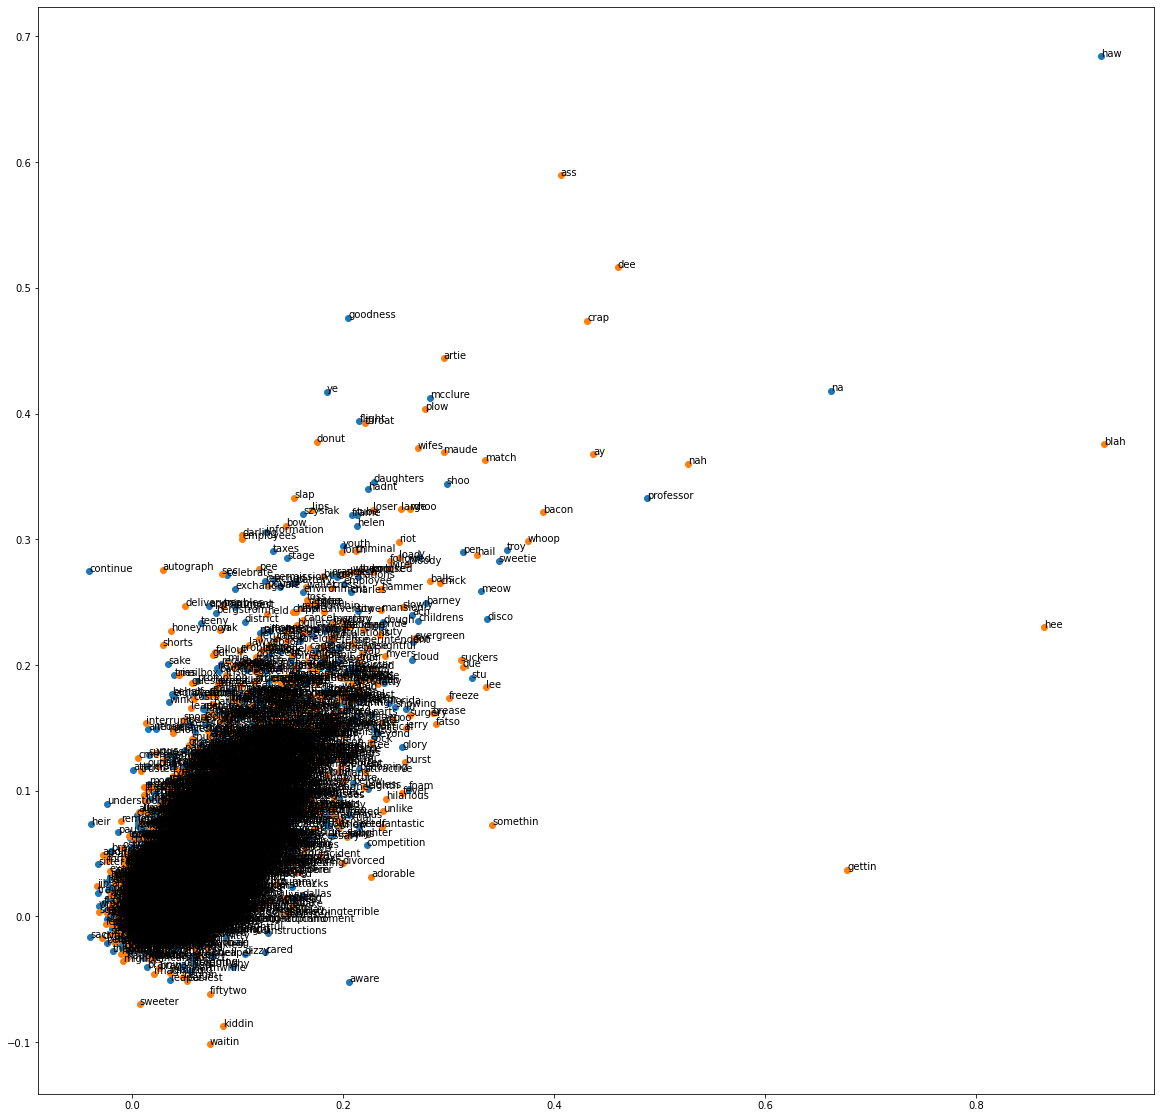

In [ ]:
for words in [word_lisa_uniq, word_bart_uniq]:
    res = model.wv[words]
    plt.scatter(res[:,0], res[:,1])
    for i, word in enumerate(words):
        plt.annotate(word, xy=(res[i, 0], res[i, 1]) )
plt.gcf().set_size_inches(20, 20)

In [12]:
batch_size = 5000
data_size = len(sents)
sent_size = 150
vec_size = model.wv.get_vector('do').shape[0]
y = [1*(o == "Lisa Simpson") + 2*(o == 'Bart Simpson')  for o in text_y[:,1]]
n_classes = len(set(y))

train = []
for i0, sent in enumerate(sents[:100000]):
    X = tr.zeros(sent_size, vec_size)
    for i1, word in enumerate(sent):
        r = tr.tensor(model.wv[word])
        X[i1] = r
    train.append((X.T, y[i0]))

test = []
for i0, sent in enumerate(sents[100000:]):
    X = tr.zeros(sent_size, vec_size)
    for i1, word in enumerate(sent):
        r = tr.tensor(model.wv[word])
        X[i1] = r
    test.append((X.T, y[i0 + 100000]))

In [15]:
data_train = tr.utils.data.DataLoader(train, batch_size = batch_size, shuffle=True)
data_test = tr.utils.data.DataLoader(test, batch_size = batch_size, shuffle=True)

In [16]:
dev = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
print(f"work on {(tr.cuda.get_device_name() if dev.type == 'cuda' else 'cpu')}")

work on Tesla P100-PCIE-16GB


In [32]:
class Net1(tr.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = tr.nn.Conv1d(100, 100, 5)
        self.norm1 = tr.nn.BatchNorm1d(100)
        self.conv2 = tr.nn.Conv1d(100, 100, 3)
        self.norm2 = tr.nn.BatchNorm1d(100)
        self.relu = tr.nn.ReLU6()
        self.flat = tr.nn.Flatten()
        self.fc1 = tr.nn.Linear(14400, n_classes)
    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.flat(x)
        x = self.fc1(x)
        return x

In [ ]:
model1 = Net1().to(dev)

In [45]:
optim = tr.optim.Adam(model1.parameters())
crit = tr.nn.CrossEntropyLoss()
n_iters = 100

for iter in range(n_iters):
    model1.train()
    for X, y in data_train:
        X, y = X.to(dev), y.to(dev)
        optim.zero_grad()
        pred = model1(X)
        loss = crit(pred, y)
        loss.backward()
        optim.step()
    train_score = tr.sum(tr.argmax(pred, axis=1) == y).item() / y.shape[0]

    model1.eval()
    for X, y in data_test:
        X, y = X.to(dev), y.to(dev)
        pred = model1(X)
        test_score = tr.sum(tr.argmax(pred, axis=1) == y).item() / y.shape[0]
        print(f'iter {iter}, loss = {loss}, train score = {train_score}, test score = {test_score}')
        break
    if test_score > 0.98:
        break

iter 0, loss = 0.2513400912284851, train score = 0.9082, test score = 0.7316
iter 1, loss = 0.16033223271369934, train score = 0.944, test score = 0.7768
iter 2, loss = 0.13243992626667023, train score = 0.958, test score = 0.7794
iter 3, loss = 0.12195853143930435, train score = 0.962, test score = 0.7646
iter 4, loss = 0.11586885899305344, train score = 0.9636, test score = 0.7796
iter 5, loss = 0.13346447050571442, train score = 0.9556, test score = 0.7802
iter 6, loss = 0.12992490828037262, train score = 0.9572, test score = 0.7614
iter 7, loss = 0.12393798679113388, train score = 0.9608, test score = 0.789
iter 8, loss = 0.1265002191066742, train score = 0.9606, test score = 0.778
iter 9, loss = 0.12691952288150787, train score = 0.957, test score = 0.7726
iter 10, loss = 0.11900845915079117, train score = 0.964, test score = 0.7738
iter 11, loss = 0.12910203635692596, train score = 0.9584, test score = 0.787
iter 12, loss = 0.11959756165742874, train score = 0.9626, test score = 